In [1]:
# Import library
from ga_inverse import *

In [2]:
# Initialize gas constants (C3H6, C3H8)
diameter_tuple = (np.array([4.03]), np.array([4.16]))
mass_tuple = (np.array([42.08]), np.array([44.1]))
ascF_tuple = (np.array([0.142]), np.array([0.152]))
kD_tuple = (np.array([4.5]), np.array([4.3]))

In [3]:
# Read data
data_from_file = readData('./MyData.xlsx')
training_data, gene_repr_of_training_data, training_x, training_y = prepareDataForLearning(data_from_file)


In [4]:
# Train model
model = trainModel(training_x, training_y)

In [5]:
# Prepare GA
## Fitness function
boundaries_D = np.array([-12.8, -12.2])
boundaries_R = np.array([1.9, 2.1])
def ga_fitness(solution, solution_idx):
    # Build upon imported fi
    return fitness_base(solution, solution_idx, diameter_tuple, mass_tuple, ascF_tuple, kD_tuple,
            boundaries_D, boundaries_R, model)

# Starting population
starting_population = training_data

# Actual initialization
ga_instance = prepareGA(fitness=ga_fitness, starting_population_data=starting_population,
                        num_generations=2)

/home/ggianna/runtimeEnvs/mambaforge/inverse-design/lib/python3.10/site-packages/pygad/pygad.py:932: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")
/home/ggianna/runtimeEnvs/mambaforge/inverse-design/lib/python3.10/site-packages/pygad/pygad.py:940: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


In [7]:
# Run GA
solution, solution_fitness, solution_index = runGA(ga_instance)

Current date and time : 
2023-03-13 20:19:15
Generation 3
[[27.     6.41   6.01   4.438  3.78   3.85   3.54 ]
 [27.     6.41   6.01   4.438  3.78   3.85   3.54 ]
 [27.     6.41   3.66   4.86   3.78   3.85   3.54 ]
 [29.     6.41   3.66   4.438  4.093  3.85   3.54 ]
 [27.     6.41   6.01   4.438  3.78   3.85   3.54 ]
 [ 4.     6.41   6.01   4.438  3.78   3.85   3.54 ]
 [12.     6.01   4.86   5.996  3.54   4.093  3.78 ]
 [29.     4.86   6.01   4.438  3.85   3.54   4.25 ]
 [27.     6.41   6.01   4.438  3.78   3.85   3.54 ]
 [30.     4.438  6.41   4.86   3.78   3.54   2.278]
 [27.     6.41   6.01   4.438  3.78   3.54   4.093]
 [27.     6.41   5.7    4.438  3.78   3.85   3.54 ]
 [48.     5.7    3.66   5.996  3.78   4.093  3.54 ]
 [48.     5.7    3.66   6.01   3.78   3.85   2.7  ]
 [29.     6.41   4.86   4.438  3.85   4.093  3.54 ]
 [27.     4.438  4.86   5.996  3.85   4.093  2.278]
 [29.     5.7    4.86   4.438  3.85   3.78   4.25 ]
 [12.     6.41   4.86   4.438  3.78   3.54   4.093]
 [27. 

In [14]:
# Get best solutions
best_solutions = get_best_solutions(ga_instance)
print(best_solutions)


# Output also best of the best
best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()


print("Parameters of the best solution : %s"%(str(best_solution)))
print("Fitness value of the best solution = %5.3f"%(best_solution_fitness))

      0     1     2      3     4      5     6
0  27.0  6.41  6.41  6.410  3.78  3.780  3.78
1  27.0  6.41  6.01  4.438  3.78  3.850  3.54
2  12.0  6.41  3.66  5.996  3.85  4.093  4.25
3  12.0  6.41  4.86  6.010  3.85  3.540  4.25
Parameters of the best solution : {[12.    6.41  4.86  6.01  3.85  3.54  4.25]}
Fitness value of the best solution = {3.333}


196.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


/bin/bash: γραμμή 1: matplotlib: εντολή δεν βρέθηκε


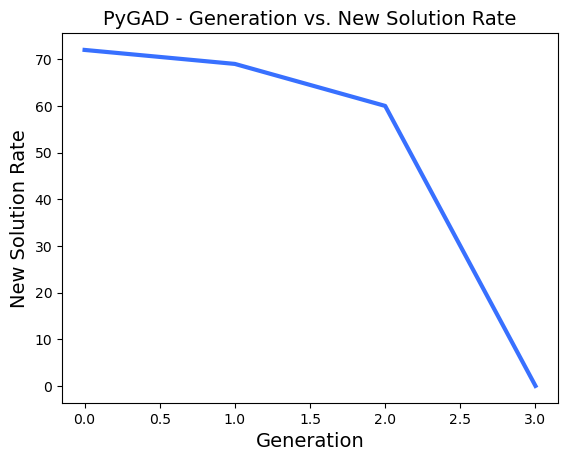

Figure(640x480)


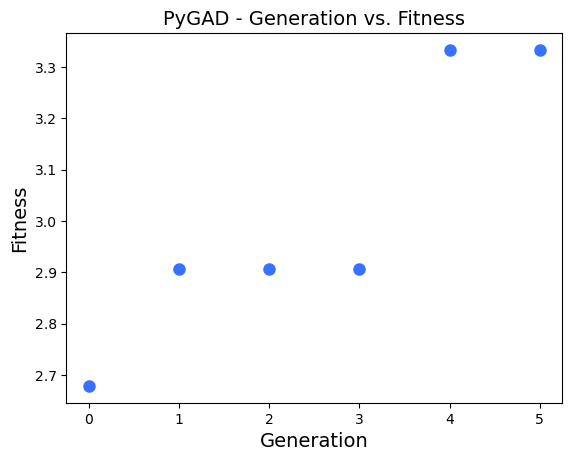

Figure(640x480)


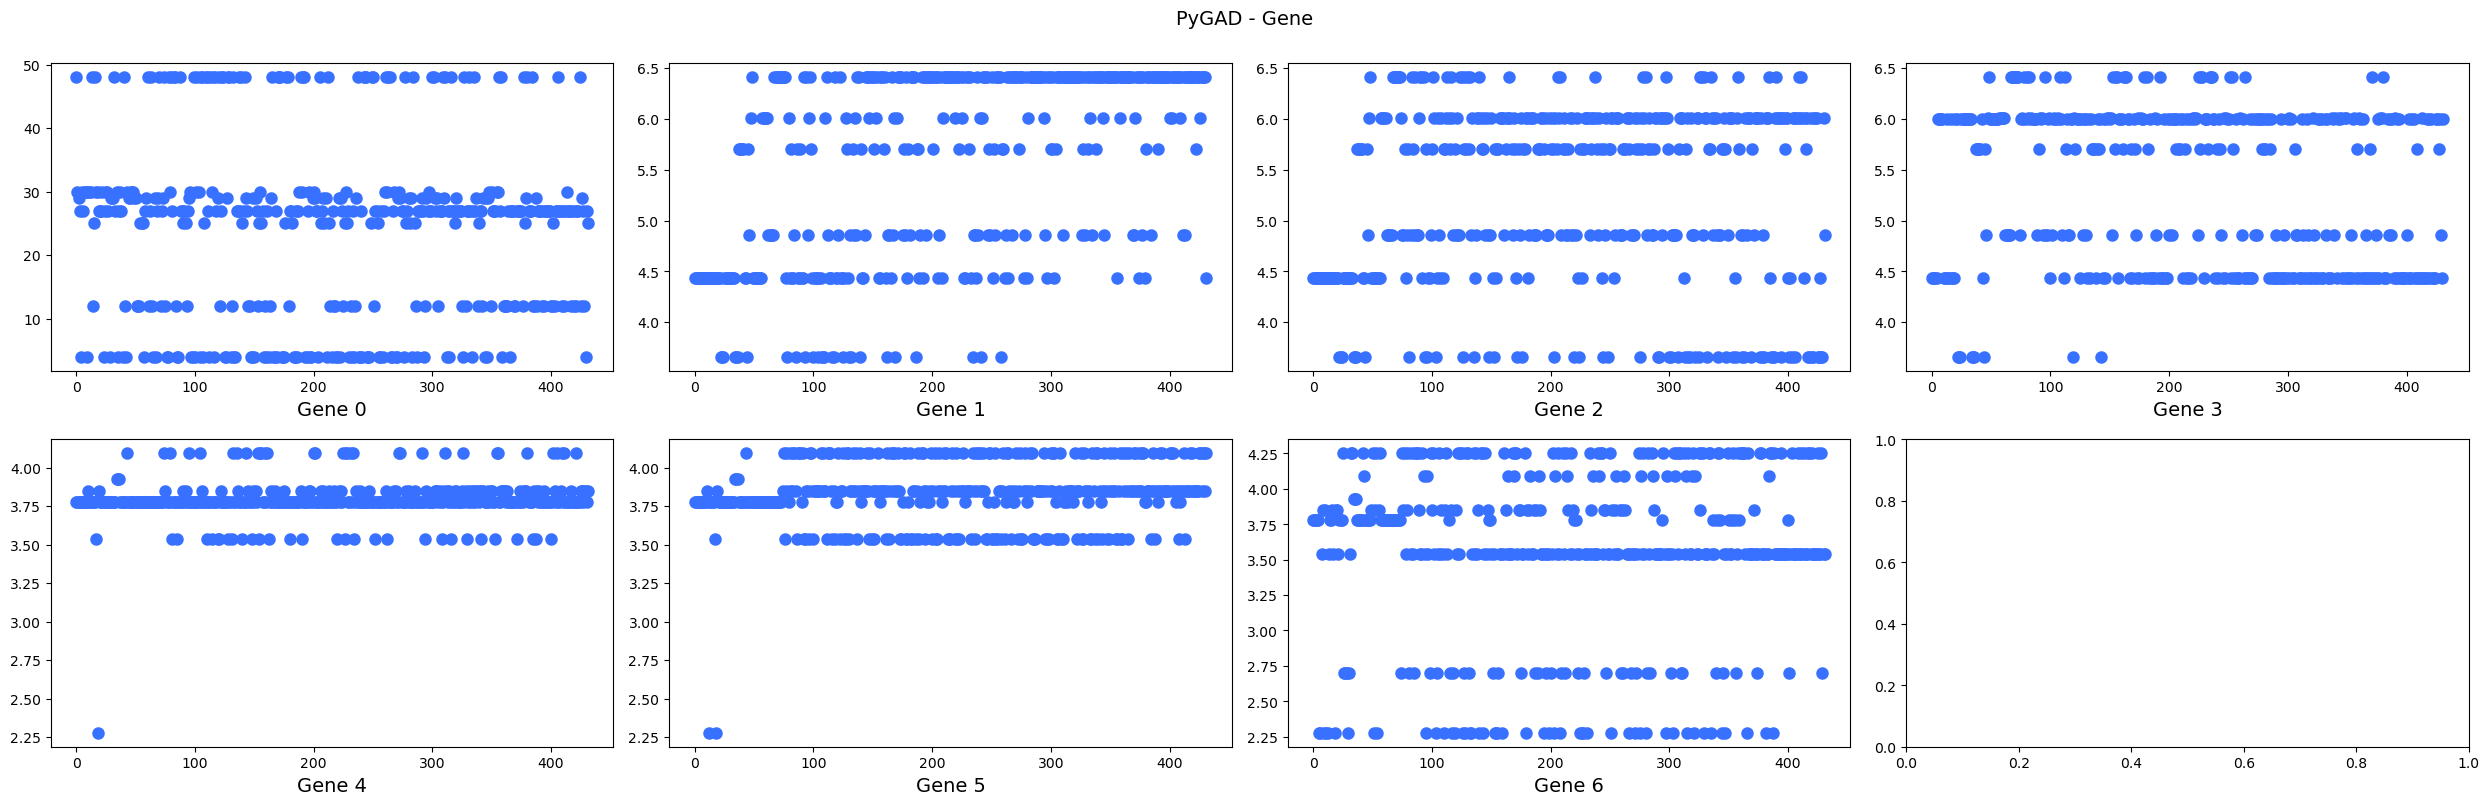

Figure(2500x800)


In [9]:
# Plot results
plot_results(ga_instance)

In [ ]:
# Output estimated solution performance
